## UKBB+HCP GLM

### Imports

In [128]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
from imports import *

In [130]:
from models import *
from data import * 
from env import *
from harmonize import *
from sim import *

In [131]:
# overall imports
import importlib
import data

# sim imports
import sim.sim 
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run, open_pickled_results

# data load
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
importlib.reload(data.data_load)
importlib.reload(data.data_viz)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import data.cv_split
from data.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(data.cv_split)

# sim class
import sim.sim 
from sim.sim import Simulation
importlib.reload(sim.sim)


<module 'sim.sim' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim.py'>

In [132]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 34.0%
RAM Usage: 6.5%
Available RAM: 352.4G
Total RAM: 377.1G
52.4G


In [133]:
GPUtil.getAvailable()

[0]

## Load in structural connectomes

In [134]:
HCP_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/HCP1200_DTI/'
print(HCP_path)

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/HCP1200_DTI/


In [135]:
# Load stuctural connectome from ENIGMA
HCP_enigma_structural_count = load_connectome(measure='SC')
HCP_enigma_structural_count_cortical = HCP_enigma_structural_count[:100, :100]

# Load 156-region structural connectivity matrices
HCP1200_S156_structural_count = np.log1p(loadmat(HCP_path + '/4S156/4S156_DTI_count.mat')['connectivity'])
HCP1200_S156_structural_count_cortical = HCP1200_S156_structural_count[:100, :100]
HCP1200_S156_structural_QA = loadmat(HCP_path + '/4S156/4S156_DTI_QA.mat')['connectivity']
HCP1200_S156_structural_QA_cortical = HCP1200_S156_structural_QA[:100, :100]

# Load 456-region structural connectivity matrices  
HCP1200_S456_structural_count = np.log1p(loadmat(HCP_path + '/4S456/4S456_DTI_count.mat')['connectivity'])
HCP1200_S456_structural_QA = loadmat(HCP_path + '/4S456/4S456_DTI_QA.mat')['connectivity']

## Load in functional connectomes

In [136]:
UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/'
print(UKBB_path)

UKBB_demographics = pd.read_csv(UKBB_path + '/metadata/UKBB_MasterList_DemogInfo_part.csv')
UKBB_demographics.head()

/scratch/asr655/neuroinformatics/GeneEx2Conn_data/Penn_UKBB_data/


MRID    Age  IsF     Race
0  1000038_2_0  64.64  1.0  British
1  1000108_2_0  68.39  0.0  British
2  1000149_2_0  76.67  0.0    Irish
3  1000201_2_0  67.24  1.0  British
4  1000213_2_0  67.73  1.0  British

In [137]:
UKBB_S156_functional_conn = pd.read_csv('./data/UKBB/UKBB_S156_functional_conn.csv')
UKBB_S156_functional_conn_cortical = np.array(UKBB_S156_functional_conn)[:100, :100]
UKBB_S156_labels = pd.read_csv('./data/UKBB/schaefer156_atlas_info.txt', sep='\t')['label_7network'].tolist()

UKBB_S456_functional_conn = pd.read_csv('./data/UKBB/UKBB_S456_functional_conn.csv')
UKBB_S456_functional_conn_cortical = np.array(UKBB_S456_functional_conn)[:400, :400]
UKBB_S456_labels = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')['label_7network'].tolist()

HCP_enigma_functional_conn = load_connectome(measure='FC', omit_subcortical=False)
HCP_enigma_functional_conn_cortical = load_connectome(measure='FC', omit_subcortical=True)
HCP_labels = pd.read_csv('./data/enigma/schaef114_regions.txt', header=None).values.flatten().tolist()


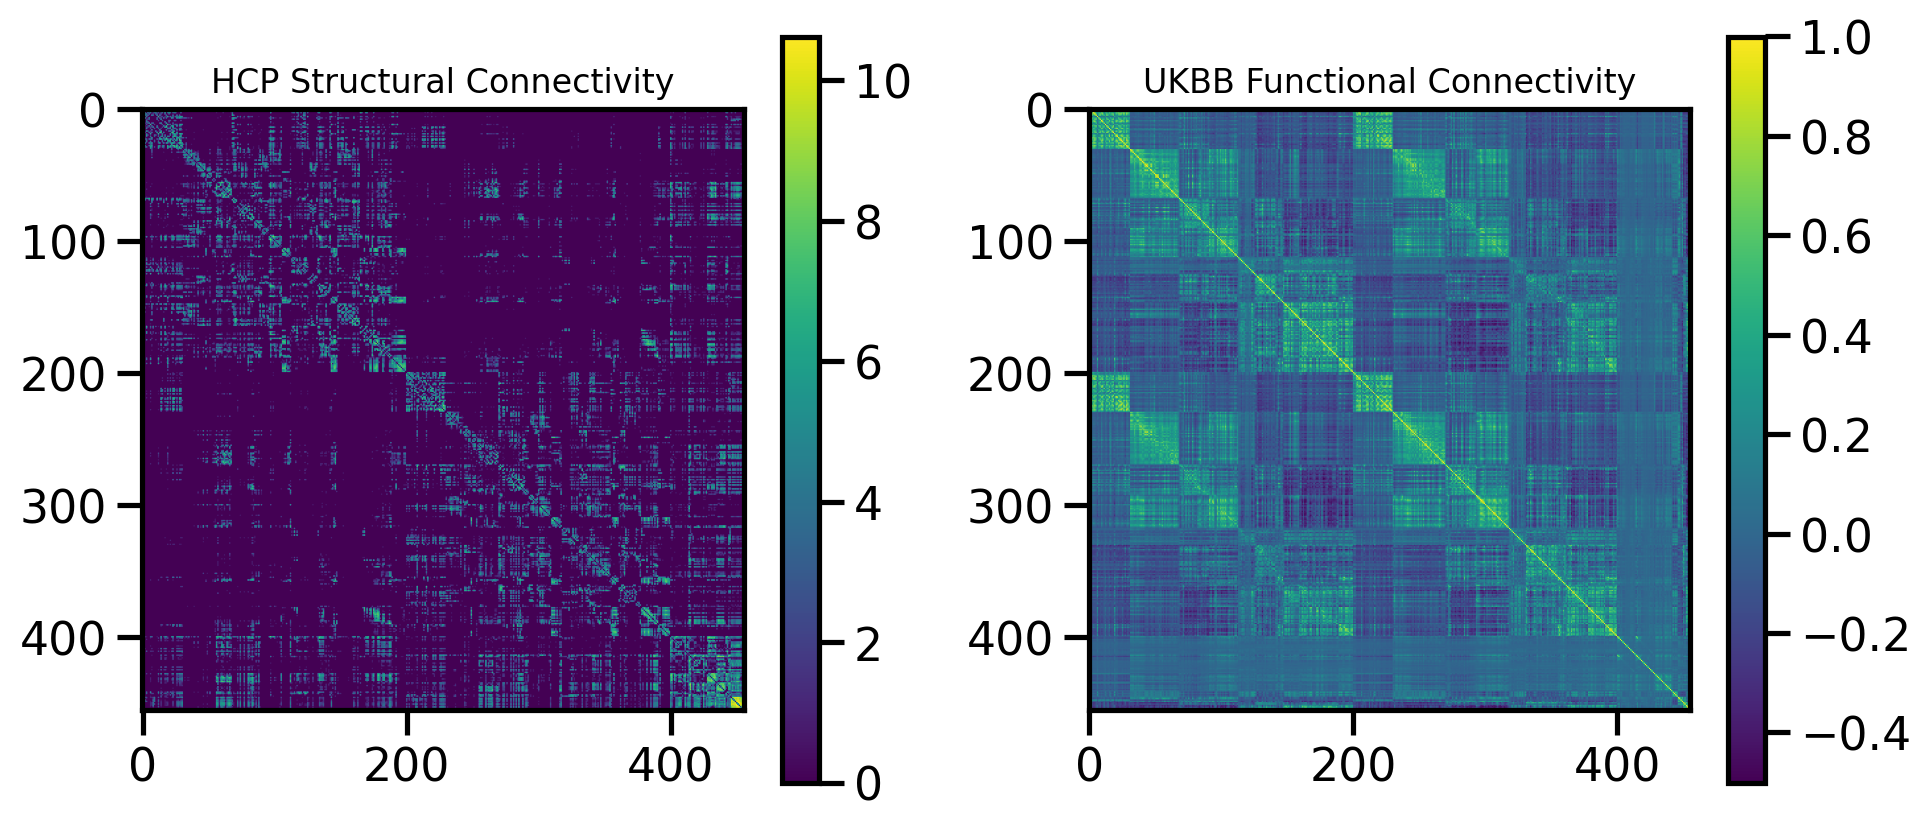

HCP Structure - UKBB Function Correlation: 0.180


In [138]:
# Visualize structural connectivity matrix from HCP and functional from UKBB
plt.figure(figsize=(10,8), dpi=200)
plt.subplot(121)
plt.imshow(HCP1200_S456_structural_count, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('HCP Structural Connectivity', fontsize=12)

plt.subplot(122)
plt.imshow(UKBB_S456_functional_conn, cmap='viridis')
plt.colorbar(shrink=0.5)
plt.title('UKBB Functional Connectivity', fontsize=12)
plt.tight_layout()
plt.show()

# Compute correlation between HCP structural and UKBB functional connectivity
struct_func_corr = np.corrcoef(np.array(HCP1200_S456_structural_count).flatten(),
                              np.array(UKBB_S456_functional_conn).flatten())[0,1]

print(f"HCP Structure - UKBB Function Correlation: {struct_func_corr:.3f}")


### S456 transcriptome and connectomes

In [139]:
# HCP1200 + UKBB (456)
AHBA_UKBB_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/Penn_UKBB_data/AHBA_population_MH/'
AHBA_S456_transcriptome = pd.read_csv(os.path.join(AHBA_UKBB_path, 'AHBA_schaefer456_mean.csv'))
AHBA_S456_transcriptome


label      A1BG  A1BG-AS1       A2M     A2ML1   A3GALT2    A4GALT  \
0        1  0.561660  0.734501  0.324933  0.535864  0.489417  0.379832   
1        2  0.663557  0.685498  0.441050  0.385992  0.346175  0.443920   
2        3  0.436262  0.643591  0.429456  0.440705  0.431365  0.281185   
3        4  0.425277  0.605727  0.423479  0.535326  0.491737  0.511346   
4        5  0.450135  0.549051  0.424298  0.482207  0.570472  0.454508   
..     ...       ...       ...       ...       ...       ...       ...   
451    452  0.341028  0.094848  0.765552  0.575811  0.704052  0.562898   
452    453  0.463658  0.186620  0.779770  0.576450  0.619368  0.611139   
453    454  0.330321  0.182710  0.778768  0.511883  0.645229  0.616889   
454    455       NaN       NaN       NaN       NaN       NaN       NaN   
455    456  0.529461  0.171250  0.734482  0.632406  0.728757  0.477470   

         AAAS      AACS   AADACL3  ...      ZW10    ZWILCH     ZWINT  \
0    0.326284  0.753036  0.515869  ...  0.418326  0.718180  0.609211   
1    0.412164  0.797134  0.389222  ...  0.426496  0.686967  0.631722   
2    0.540874  0.736296  0.423710  ...  0.499867  0.573895  0.473315   
3    0.550680  0.797199  0.506673  ...  0.598042  0.524854  0.529094   
4    0.502276  0.705437  0.528914  ...  0.437076  0.542980  0.342298   
..        ...       ...       ...  ...       ...       ...       ...   
451  0.461932  0.194017  0.741957  ...  0.369983  0.315040  0.265321   
452  0.491830  0.198539  0.715724  ...  0.485183  0.264759  0.221240   
453  0.622842  0.200763  0.715024  ...  0.430804  0.199255  0.221837   
454       NaN       NaN       NaN  ...       NaN       NaN       NaN   
455  0.378586  0.111168  0.764168  ...  0.288623  0.199032  0.178801   

         ZXDA      ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1      ZZZ3  
0    0.559397  0.536330  0.543115  0.781127  0.494951  0.548834  0.421155  
1    0.469606  0.454834  0.465253  0.669610  0.508163  0.423381  0.551138  
2    0.455233  0.478429  0.496601  0.735628  0.647218  0.597632  0.566405  
3    0.356172  0.607706  0.395900  0.682981  0.737804  0.598276  0.452306  
4    0.269446  0.545493  0.550851  0.610388  0.740635  0.548234  0.285249  
..        ...       ...       ...       ...       ...       ...       ...  
451  0.670809  0.776702  0.528139  0.249857  0.221722  0.430635  0.519660  
452  0.508757  0.526605  0.645608  0.192872  0.440912  0.724691  0.503096  
453  0.603498  0.548253  0.459224  0.224987  0.424326  0.709733  0.528174  
454       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
455  0.734727  0.642548  0.643569  0.203967  0.286378  0.592497  0.520681  

[456 rows x 15634 columns]

In [140]:
#UKBB_S456_atlas_info = pd.read_csv('./data/UKBB/schaefer456_atlas_info.txt', sep='\t')
UKBB_S456_atlas_info_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/GeneEx2Conn_data/atlas_info/atlas-4S456Parcels_dseg_reformatted.csv'
UKBB_S456_atlas_info = pd.read_csv(UKBB_S456_atlas_info_path)

# Fill NaN network labels based on region labels
UKBB_S456_atlas_info.loc[(UKBB_S456_atlas_info['label'].str.contains('Cerebellar', na=False)) & 
                         (UKBB_S456_atlas_info['network_label'].isna()), 'network_label'] = 'Cerebellum'

UKBB_S456_atlas_info.loc[(UKBB_S456_atlas_info['network_label'].isna()), 'network_label'] = 'Subcortex'
print(UKBB_S456_atlas_info)


                   label network_label      label_7network  index_17network  \
0               LH_Vis_1           Vis  7Networks_LH_Vis_1             61.0   
1               LH_Vis_2           Vis  7Networks_LH_Vis_2            193.0   
2               LH_Vis_3           Vis  7Networks_LH_Vis_3              1.0   
3               LH_Vis_4           Vis  7Networks_LH_Vis_4             13.0   
4               LH_Vis_5           Vis  7Networks_LH_Vis_5              2.0   
..                   ...           ...                 ...              ...   
451   Cerebellar_Region6    Cerebellum                 NaN              NaN   
452   Cerebellar_Region7    Cerebellum                 NaN              NaN   
453   Cerebellar_Region8    Cerebellum                 NaN              NaN   
454   Cerebellar_Region9    Cerebellum                 NaN              NaN   
455  Cerebellar_Region10    Cerebellum                 NaN              NaN   

                       label_17network network_labe

In [141]:
# Drop rows where all values are NaN
print("Number of rows with any NaN values:", AHBA_S456_transcriptome.isna().any(axis=1).sum())

nan_rows = AHBA_S456_transcriptome.isna().any(axis=1)
AHBA_S456_transcriptome = AHBA_S456_transcriptome[~nan_rows]
UKBB_S456_atlas_info = UKBB_S456_atlas_info[~nan_rows]

# Check if any NaN values remain
print("Number of rows with any NaN values:", AHBA_S456_transcriptome.isna().any(axis=1).sum())

Number of rows with any NaN values: 66
Number of rows with any NaN values: 0


In [142]:
AHBA_S456_transcriptome = AHBA_S456_transcriptome.drop('label', axis=1)
AHBA_S456_transcriptome

A1BG  A1BG-AS1       A2M     A2ML1   A3GALT2    A4GALT      AAAS  \
0    0.561660  0.734501  0.324933  0.535864  0.489417  0.379832  0.326284   
1    0.663557  0.685498  0.441050  0.385992  0.346175  0.443920  0.412164   
2    0.436262  0.643591  0.429456  0.440705  0.431365  0.281185  0.540874   
3    0.425277  0.605727  0.423479  0.535326  0.491737  0.511346  0.550680   
4    0.450135  0.549051  0.424298  0.482207  0.570472  0.454508  0.502276   
..        ...       ...       ...       ...       ...       ...       ...   
450  0.356165  0.136111  0.794895  0.432077  0.550255  0.820798  0.693197   
451  0.341028  0.094848  0.765552  0.575811  0.704052  0.562898  0.461932   
452  0.463658  0.186620  0.779770  0.576450  0.619368  0.611139  0.491830   
453  0.330321  0.182710  0.778768  0.511883  0.645229  0.616889  0.622842   
455  0.529461  0.171250  0.734482  0.632406  0.728757  0.477470  0.378586   

         AACS   AADACL3     AADAT  ...      ZW10    ZWILCH     ZWINT  \
0    0.753036  0.515869  0.657180  ...  0.418326  0.718180  0.609211   
1    0.797134  0.389222  0.608480  ...  0.426496  0.686967  0.631722   
2    0.736296  0.423710  0.706882  ...  0.499867  0.573895  0.473315   
3    0.797199  0.506673  0.609379  ...  0.598042  0.524854  0.529094   
4    0.705437  0.528914  0.501061  ...  0.437076  0.542980  0.342298   
..        ...       ...       ...  ...       ...       ...       ...   
450  0.242186  0.777254  0.096343  ...  0.289390  0.340671  0.309953   
451  0.194017  0.741957  0.298705  ...  0.369983  0.315040  0.265321   
452  0.198539  0.715724  0.273334  ...  0.485183  0.264759  0.221240   
453  0.200763  0.715024  0.291594  ...  0.430804  0.199255  0.221837   
455  0.111168  0.764168  0.306604  ...  0.288623  0.199032  0.178801   

         ZXDA      ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1      ZZZ3  
0    0.559397  0.536330  0.543115  0.781127  0.494951  0.548834  0.421155  
1    0.469606  0.454834  0.465253  0.669610  0.508163  0.423381  0.551138  
2    0.455233  0.478429  0.496601  0.735628  0.647218  0.597632  0.566405  
3    0.356172  0.607706  0.395900  0.682981  0.737804  0.598276  0.452306  
4    0.269446  0.545493  0.550851  0.610388  0.740635  0.548234  0.285249  
..        ...       ...       ...       ...       ...       ...       ...  
450  0.747729  0.684998  0.626211  0.235771  0.563802  0.611799  0.575709  
451  0.670809  0.776702  0.528139  0.249857  0.221722  0.430635  0.519660  
452  0.508757  0.526605  0.645608  0.192872  0.440912  0.724691  0.503096  
453  0.603498  0.548253  0.459224  0.224987  0.424326  0.709733  0.528174  
455  0.734727  0.642548  0.643569  0.203967  0.286378  0.592497  0.520681  

[390 rows x 15633 columns]

In [143]:
# Get list of genes from schaefer 100 data
genes_data = pd.read_csv(f"./data/enigma/allgenes_stable_r0.2_schaefer_100.csv")
genes_list = genes_data.columns.tolist()
genes_list.remove('label')

# Subset AHBA_S456 to only include these genes 
AHBA_S456_transcriptome = AHBA_S456_transcriptome[genes_list]


AHBA_S456_transcriptome shape: (390, 11053)
HCP1200_S456_structural_count shape: (456, 456)
UKBB_S456_functional_conn shape: (456, 456)


Text(0.5, 1.0, 'HCP1200 Structural Connectivity (nan rows removed)')

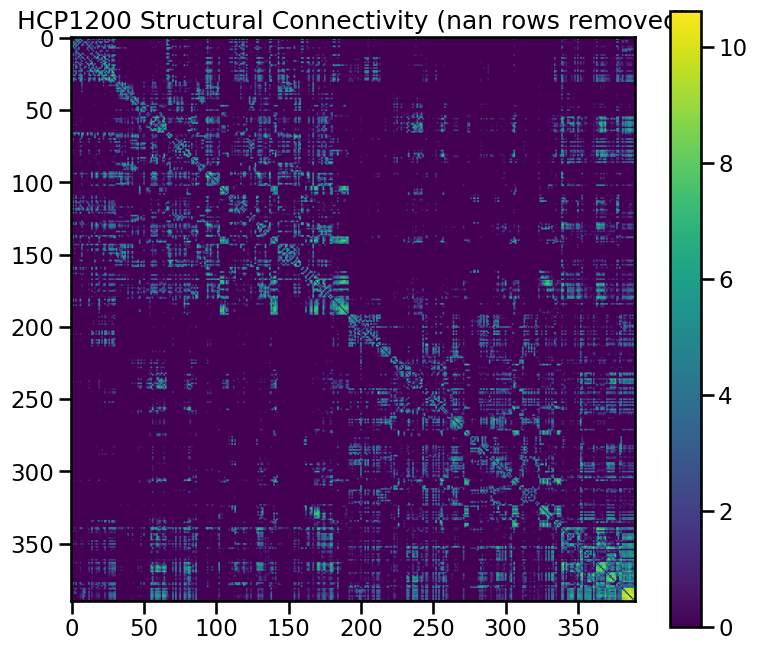

In [144]:
print("AHBA_S456_transcriptome shape:", AHBA_S456_transcriptome.shape)
print("HCP1200_S456_structural_count shape:", HCP1200_S456_structural_count.shape)
print("UKBB_S456_functional_conn shape:", UKBB_S456_functional_conn.shape)

# Store labels and network labels from atlas info
region_labels = UKBB_S456_atlas_info['label'].tolist()
network_labels = UKBB_S456_atlas_info['network_label'].tolist()
# Store MNI coordinates from atlas info as list of [x,y,z] coordinates
mni_coords = [[x, y, z] for x, y, z in zip(UKBB_S456_atlas_info['mni_x'], 
                                          UKBB_S456_atlas_info['mni_y'],
                                          UKBB_S456_atlas_info['mni_z'])]

# Remove nan rows and columns from connectomes using nan_rows directly
HCP1200_S456_structural_count = HCP1200_S456_structural_count[~nan_rows][:, ~nan_rows]

# Display resulting connectomes
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.imshow(HCP1200_S456_structural_count, cmap='viridis')
plt.colorbar()
plt.title('HCP1200 Structural Connectivity (nan rows removed)')


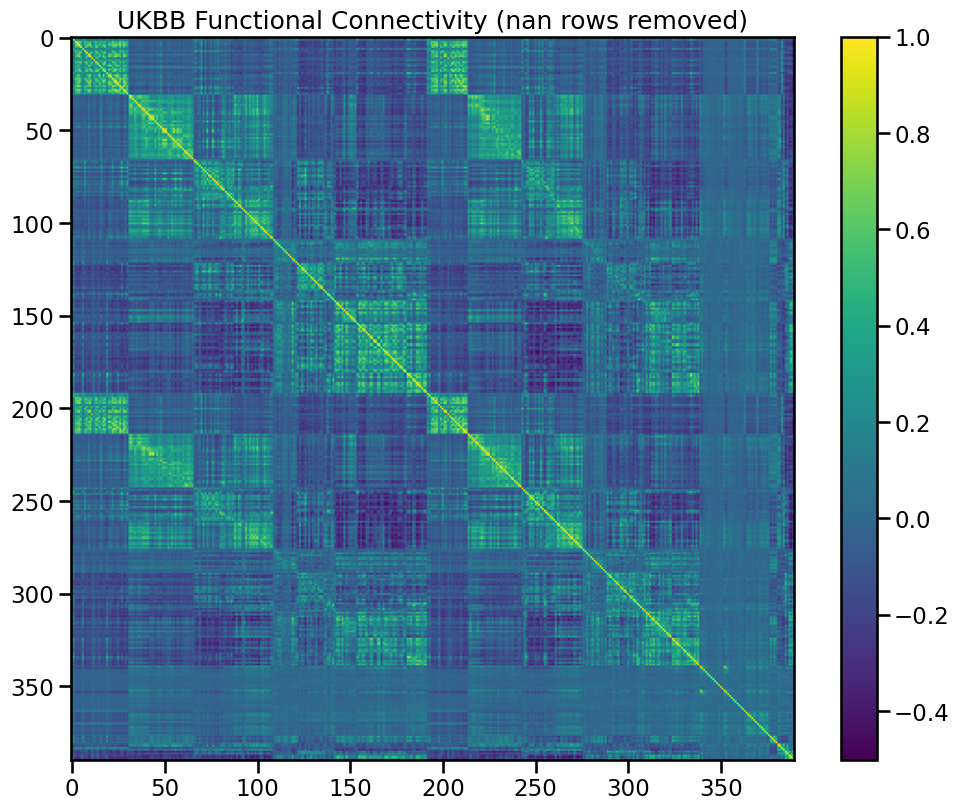

In [145]:

plt.figure(figsize=(20, 8))

UKBB_S456_functional_conn = np.array(UKBB_S456_functional_conn)[~nan_rows][:, ~nan_rows]
plt.subplot(122)
plt.imshow(UKBB_S456_functional_conn, cmap='viridis')
plt.colorbar()
plt.title('UKBB Functional Connectivity (nan rows removed)')

plt.tight_layout()
plt.show()

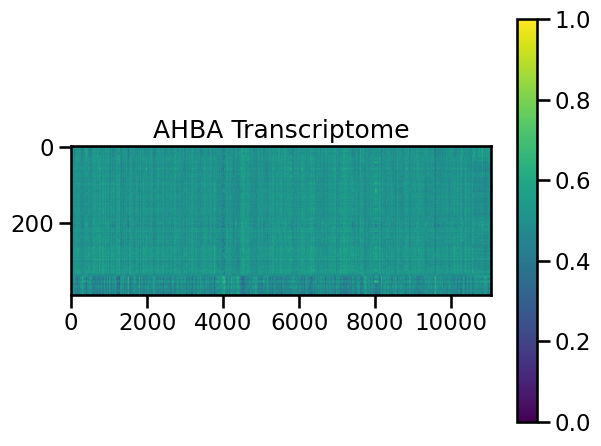

In [146]:
plt.imshow(AHBA_S456_transcriptome, cmap='viridis', aspect=10)
plt.title('AHBA Transcriptome')
plt.colorbar()
plt.tight_layout()
plt.show()


In [147]:
print("Network labels shape:", len(network_labels))
print("Region labels shape:", len(region_labels))
print("MNI coordinates shape:", len(mni_coords))

Network labels shape: 390
Region labels shape: 390
MNI coordinates shape: 390


In [148]:
print("AHBA_S456_transcriptome shape:", AHBA_S456_transcriptome.shape)
print("HCP1200_S456_structural_count shape:", HCP1200_S456_structural_count.shape)
print("UKBB_S456_functional_conn shape:", UKBB_S456_functional_conn.shape)

AHBA_S456_transcriptome shape: (390, 11053)
HCP1200_S456_structural_count shape: (390, 390)
UKBB_S456_functional_conn shape: (390, 390)


In [149]:
# Filter out subcortex and cerebellum networks
cortical_mask = ~np.array([label in ['Subcortex', 'Cerebellum'] for label in network_labels])
AHBA_cortical_transcriptome = np.array(AHBA_S456_transcriptome)[cortical_mask]
cortical_network_labels = np.array(network_labels)[cortical_mask]
cortical_region_labels = np.array(region_labels)[cortical_mask]
cortical_mni_coords = np.array(mni_coords)[cortical_mask]

# Filter structural and functional connectivity matrices using cortical mask
HCP1200_S456_structural_count_cortical = np.array(HCP1200_S456_structural_count)[cortical_mask][:, cortical_mask]
UKBB_S456_functional_conn_cortical = np.array(UKBB_S456_functional_conn)[cortical_mask][:, cortical_mask]

print("Cortical transcriptome shape:", AHBA_cortical_transcriptome.shape)
print("Cortical structural connectivity shape:", HCP1200_S456_structural_count_cortical.shape)
print("Cortical functional connectivity shape:", UKBB_S456_functional_conn_cortical.shape)

Cortical transcriptome shape: (339, 11053)
Cortical structural connectivity shape: (339, 339)
Cortical functional connectivity shape: (339, 339)


In [150]:
cortical_region_labels

array(['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5',
       'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10',
       'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15',
       'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20',
       'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25',
       'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30',
       'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3',
       'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7',
       'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11',
       'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15',
       'LH_SomMot_16', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20',
       'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24',
       'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28',
       'LH_SomMot_29', 'LH_SomMot_30', 'LH_SomMot_31', 'LH_SomMot_32',
       'LH_SomMot_33'

#### Create subdatasets for left hemisphere, right hemisphere, and interconnections

Left hemisphere

In [151]:
# Isolate nodes from the left hemisphere only
# Create mask for left hemisphere regions
left_hemi_mask = np.array([label.startswith('LH_') for label in cortical_region_labels])

# Apply mask to all relevant arrays
AHBA_left_transcriptome = AHBA_cortical_transcriptome[left_hemi_mask]
left_network_labels = cortical_network_labels[left_hemi_mask]
left_region_labels = cortical_region_labels[left_hemi_mask]
left_mni_coords = cortical_mni_coords[left_hemi_mask]

# For connectivity matrices, need to mask both rows and columns
HCP1200_S456_structural_count_left = HCP1200_S456_structural_count_cortical[left_hemi_mask][:, left_hemi_mask]
UKBB_S456_functional_conn_left = UKBB_S456_functional_conn_cortical[left_hemi_mask][:, left_hemi_mask]

print("Left hemisphere transcriptome shape:", AHBA_left_transcriptome.shape)
print("Left hemisphere structural connectivity shape:", HCP1200_S456_structural_count_left.shape)
print("Left hemisphere functional connectivity shape:", UKBB_S456_functional_conn_left.shape)


Left hemisphere transcriptome shape: (192, 11053)
Left hemisphere structural connectivity shape: (192, 192)
Left hemisphere functional connectivity shape: (192, 192)


Right hemisphere

In [152]:
# Isolate nodes from the left hemisphere only
# Create mask for left hemisphere regions
right_hemi_mask = np.array([label.startswith('RH_') for label in cortical_region_labels])

# Apply mask to all relevant arrays
AHBA_right_transcriptome = AHBA_cortical_transcriptome[right_hemi_mask]
right_network_labels = cortical_network_labels[right_hemi_mask]
right_region_labels = cortical_region_labels[right_hemi_mask]
right_mni_coords = cortical_mni_coords[right_hemi_mask]

# For connectivity matrices, need to mask both rows and columns
HCP1200_S456_structural_count_right = HCP1200_S456_structural_count_cortical[right_hemi_mask][:, right_hemi_mask]
UKBB_S456_functional_conn_right = UKBB_S456_functional_conn_cortical[right_hemi_mask][:, right_hemi_mask]

print("Right hemisphere transcriptome shape:", AHBA_right_transcriptome.shape)
print("Right hemisphere structural connectivity shape:", HCP1200_S456_structural_count_right.shape)
print("Right hemisphere functional connectivity shape:", UKBB_S456_functional_conn_right.shape)

# Note: there are fewer regions sampled in the right hemisphere than the left in AHBA dataset

Right hemisphere transcriptome shape: (147, 11053)
Right hemisphere structural connectivity shape: (147, 147)
Right hemisphere functional connectivity shape: (147, 147)


Interconnections

In [153]:
# For connectivity matrices, need to mask both rows and columns
HCP1200_S456_structural_count_interconnections = HCP1200_S456_structural_count_cortical[left_hemi_mask][:, right_hemi_mask]
UKBB_S456_functional_conn_interconnections = UKBB_S456_functional_conn_cortical[left_hemi_mask][:, right_hemi_mask]

print("Interconnections structural connectivity shape:", HCP1200_S456_structural_count_interconnections.shape)
print("Interconnections functional connectivity shape:", UKBB_S456_functional_conn_interconnections.shape)

Interconnections structural connectivity shape: (192, 147)
Interconnections functional connectivity shape: (192, 147)


### Modeling tests

#### Construct the features for the GLM 

All edges

In [154]:
# Define dataset
X = AHBA_cortical_transcriptome
Y_sc = HCP1200_S456_structural_count_cortical
Y_fc = UKBB_S456_functional_conn_cortical

cortical_network_labels = np.array(network_labels)[cortical_mask]
cortical_region_labels = np.array(region_labels)[cortical_mask]
cortical_mni_coords = np.array(mni_coords)[cortical_mask]
cortical_mask = np.array([True] * len(cortical_region_labels))


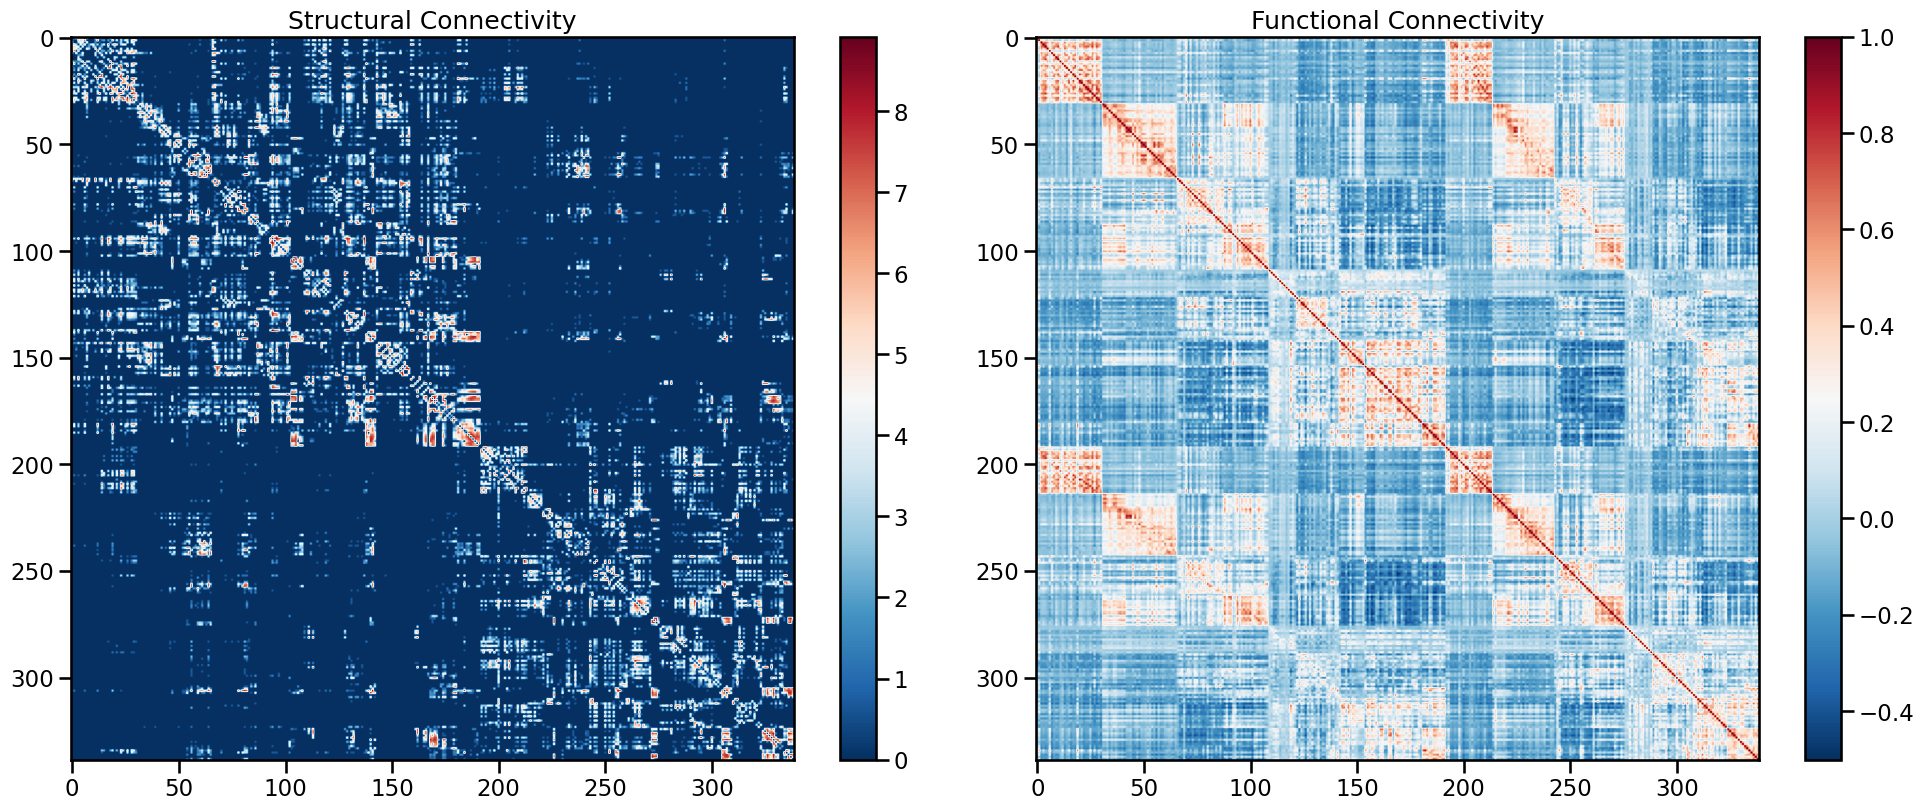

In [166]:
# Visualize structural and functional connectivity matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

im1 = ax1.imshow(Y_sc, cmap='RdBu_r')
ax1.set_title('Structural Connectivity')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(Y_fc, cmap='RdBu_r')
ax2.set_title('Functional Connectivity') 
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


In [155]:
def construct_features_masked(X, Y_sc, Y_fc, mni_coords, mask_from, mask_to):
    """
    Construct features for GLM modeling from input data matrices using masks to specify regions.
    
    Args:
        X: Full gene expression data matrix (AHBA_cortical_transcriptome)
        Y_sc: Full structural connectivity matrix
        Y_fc: Full functional connectivity matrix  
        mni_coords: MNI coordinates for all regions
        mask_from: Boolean mask for source regions (e.g. cortical_mask, left_hemi_mask)
        mask_to: Boolean mask for target regions (e.g. cortical_mask, right_hemi_mask)
        
    Returns:
        Dictionary containing feature arrays and embeddings for the masked subset
    """
    # Get masked coordinates and connectivity matrices
    mni_coords_from = mni_coords[mask_from]
    mni_coords_to = mni_coords[mask_to]
    
    # Get masked gene expression
    X_masked = X[mask_from]
    
    # Get masked connectivity matrices
    Y_sc_masked = Y_sc[mask_from][:, mask_to]
    Y_fc_masked = Y_fc[mask_from][:, mask_to]

    # Compute PCA of gene expression data - determine components for 95% variance
    pca = PCA()
    X_pca_full = pca.fit_transform(X)  # Use unmasked X
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= 0.95) + 1
    X_pca = X_pca_full[mask_from, :n_components]  # Apply mask after PCA

    # Compute spectral embeddings using method 'A' on unmasked structural connectivity
    _, eigenvectors = eig(Y_sc)  # Use unmasked Y_sc
    spectral_embeddings = eigenvectors[mask_from, :20]  # Apply mask after computing eigenvectors

    # Calculate features between all pairs of masked regions
    num_from = len(mni_coords_from)
    num_to = len(mni_coords_to)
    
    distances = []
    sc_values = []
    fc_values = [] 
    gene_coexpression = []
    gene_PCA_coexpression = []
    spectral_similarity = []
    edge_PCA_embeddings = []
    edge_spectral_embeddings = []
    edge_mni_coords = []

    for i in range(num_from):
        for j in range(num_to):
            # Skip self-connections if masks overlap
            if mask_from is mask_to and i >= j:
                continue
                
            # Calculate euclidean distance between regions i and j
            dist = np.sqrt(np.sum((mni_coords_from[i] - mni_coords_to[j])**2))
            distances.append(dist)
            
            # Get connectivity values between regions i and j
            sc_values.append(Y_sc_masked[i, j])
            fc_values.append(Y_fc_masked[i, j])
            
            # Calculate gene expression similarity
            gene_coexp = np.corrcoef(X_masked[i], X_masked[j])[0,1]
            gene_coexpression.append(gene_coexp)
            
            # Calculate PCA-based gene expression similarity
            gene_pca_coexp = np.corrcoef(X_pca[i], X_pca[j])[0,1]
            gene_PCA_coexpression.append(gene_pca_coexp)
            
            # Calculate spectral embedding similarity
            spec_sim = np.corrcoef(spectral_embeddings[i], spectral_embeddings[j])[0,1]
            spectral_similarity.append(spec_sim)
            
            # Store embeddings
            edge_PCA_embeddings.append(np.concatenate([X_pca[i], X_pca[j]]))
            edge_spectral_embeddings.append(np.concatenate([spectral_embeddings[i], spectral_embeddings[j]]))
            edge_mni_coords.append(np.concatenate([mni_coords_from[i], mni_coords_to[j]]))

    # Convert lists to arrays
    features = {
        'distances': np.array(distances),
        'sc_values': np.array(sc_values),
        'fc_values': np.array(fc_values),
        'gene_coexpression': np.array(gene_coexpression),
        'gene_PCA_coexpression': np.array(gene_PCA_coexpression),
        'spectral_similarity': np.array(spectral_similarity),
        'edge_PCA_embeddings': np.array(edge_PCA_embeddings),
        'edge_spectral_embeddings': np.array(edge_spectral_embeddings),
        'edge_mni_coords': np.array(edge_mni_coords)
    }
    
    return features

In [156]:
# def construct_features(X, Y_sc, Y_fc, mni_coords):
#     """
#     Construct features for GLM modeling from input data matrices.
    
#     Args:
#         X: Gene expression data matrix
#         Y_sc: Structural connectivity matrix 
#         Y_fc: Functional connectivity matrix
#         mni_coords: MNI coordinates for regions
        
#     Returns:
#         Dictionary containing feature arrays and embeddings
#     """
#     # Compute PCA of gene expression data - determine components for 95% variance
#     pca = PCA()
#     X_pca_full = pca.fit_transform(X)
#     cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
#     n_components = np.argmax(cumulative_variance >= 0.95) + 1
#     X_pca = X_pca_full[:, :n_components]

#     # Compute spectral embeddings using method 'A' on Y_sc
#     _, eigenvectors = eig(Y_sc)
#     spectral_embeddings = eigenvectors[:, :20]  # Use the first 20 eigenvectors

#     # Calculate euclidean distances between all pairs of regions, skipping diagonals
#     num_regions = len(mni_coords)
#     distances = []
#     sc_values = []
#     fc_values = [] 
#     gene_coexpression = []
#     gene_PCA_coexpression = []
#     spectral_similarity = []
#     edge_PCA_embeddings = []
#     edge_spectral_embeddings = []
#     edge_mni_coords = []

#     for i in range(num_regions):
#         for j in range(i+1, num_regions):
#             # Calculate euclidean distance between regions i and j
#             dist = np.sqrt(np.sum((mni_coords[i] - mni_coords[j])**2))
#             distances.append(dist)
            
#             # Get structural connectivity value between regions i and j
#             sc_val = Y_sc[i, j]
#             sc_values.append(sc_val)
            
#             # Get functional connectivity value between regions i and j
#             fc_val = Y_fc[i, j]
#             fc_values.append(fc_val)
            
#             # Calculate gene coexpression between regions i and j
#             gene_coexp = np.corrcoef(X[i, :], X[j, :])[0, 1]
#             gene_coexpression.append(gene_coexp)
            
#             # Calculate gene PCA coexpression between regions i and j
#             gene_PCA_coexp = np.corrcoef(X_pca[i, :], X_pca[j, :])[0, 1]
#             gene_PCA_coexpression.append(gene_PCA_coexp)
            
#             # Calculate spectral similarity between regions i and j
#             spectral_sim = np.corrcoef(spectral_embeddings[i, :], spectral_embeddings[j, :])[0, 1]
#             spectral_similarity.append(spectral_sim)
            
#             # Store PCA embeddings for edge (i,j)
#             edge_PCA = np.concatenate([X_pca[i], X_pca[j]])
#             edge_PCA_embeddings.append(edge_PCA)
            
#             # Store spectral embeddings for edge (i,j)
#             edge_spectral = np.concatenate([spectral_embeddings[i], spectral_embeddings[j]])
#             edge_spectral_embeddings.append(edge_spectral)

#             # Store MNI coordinates for both regions
#             edge_mni = np.concatenate([mni_coords[i], mni_coords[j]])
#             edge_mni_coords.append(edge_mni)
            
#             # Check for NaNs in the dataset
#             if np.isnan(dist) or np.isnan(sc_val) or np.isnan(fc_val) or np.isnan(gene_coexp) or np.isnan(gene_PCA_coexp) or np.isnan(spectral_sim):
#                 print(f"NaN detected at indices ({i}, {j})")

#     return {
#         'distances': np.array(distances),
#         'sc_values': np.array(sc_values),
#         'fc_values': np.array(fc_values),
#         'gene_coexpression': np.array(gene_coexpression),
#         'gene_PCA_coexpression': np.array(gene_PCA_coexpression),
#         'spectral_similarity': np.array(spectral_similarity),
#         'edge_PCA_embeddings': np.array(edge_PCA_embeddings),
#         'edge_spectral_embeddings': np.array(edge_spectral_embeddings),
#         'edge_mni_coords': np.array(edge_mni_coords)
#     }

# Call the function with our datasets
features = construct_features_masked(
    X=AHBA_cortical_transcriptome,
    Y_sc=HCP1200_S456_structural_count_cortical, 
    Y_fc=UKBB_S456_functional_conn_cortical,
    mni_coords=cortical_mni_coords,
    mask_from=cortical_mask,
    mask_to=cortical_mask
)

print("Distances shape:", features['distances'].shape)
print("SC values shape:", features['sc_values'].shape)
print("FC values shape:", features['fc_values'].shape)
print("Gene coexpression shape:", features['gene_coexpression'].shape)
print("Gene PCA coexpression shape:", features['gene_PCA_coexpression'].shape)
print("Spectral similarity shape:", features['spectral_similarity'].shape)
print("Gene PCA shape:", features['edge_PCA_embeddings'].shape)
print("Spectral embeddings shape:", features['edge_spectral_embeddings'].shape)
print("MNI coordinates shape:", features['edge_mni_coords'].shape)

def analyze_feature_correlations(features, feature_names=None, labels=None):
    """
    Analyze correlations between features and check for NaN values.
    
    Parameters:
    features (dict): Dictionary containing feature arrays
    feature_names (list): List of feature names to analyze. If None, uses default list.
    labels (list): List of labels for plotting. If None, uses default list.
    """
    if feature_names is None:
        feature_names = ['distances', 'sc_values', 'fc_values', 'gene_coexpression', 
                        'gene_PCA_coexpression', 'spectral_similarity']
    if labels is None:
        labels = ['Distance', 'SC', 'FC', 'Gene Coexp', 'Gene PCA', 'Spectral']
        
    # Check for NaNs in each feature
    for name in feature_names:
        nan_mask = np.isnan(features[name])
        if np.any(nan_mask):
            print(f"NaNs detected in {name} at indices: {np.where(nan_mask)}")

    # Compute correlations between all pairs of features
    n = len(feature_names)
    correlations = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            correlations[i,j] = np.corrcoef(features[feature_names[i]], 
                                          features[feature_names[j]])[0,1]

    # Create heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(correlations,
                xticklabels=labels,
                yticklabels=labels, 
                annot=True,
                fmt='.3f',
                cmap='RdBu_r',
                center=0,
                vmin=-1,
                vmax=1,
                square=True)
    plt.title('Correlations')
    plt.tight_layout()
    plt.show()

    # Print individual correlations for reference
    print("\nDetailed correlations:")
    for i in range(n):
        for j in range(i+1,n):
            print(f"Correlation between {labels[i]} and {labels[j]}: {correlations[i,j]:.3f}")
            
    return correlations


def fit_glm(features, feature_names, target_name='fc_values'):
    """
    Fit GLM model with specified features and calculate individual R^2 values
    
    Parameters:
    features (dict): Dictionary containing feature arrays
    feature_names (list): List of feature names to include in model
    target_name (str): Name of target feature to predict (default: 'fc_values')
    """
    # Get target variable
    target = features[target_name]
    
    # Prepare data for GLM
    X_glm = np.column_stack([features[name] for name in feature_names])
    X_glm = sm.add_constant(X_glm)  # Add constant
    
    print("Feature matrix shape:", X_glm.shape)
    
    # Fit full model
    model = sm.OLS(target, X_glm)
    results = model.fit()
    
    # Print full model summary
    print("\nFull model summary:")
    print(results.summary())
    
    # Calculate R^2 for individual features
    print("\nIndividual feature R^2 values:")
    r_squared_values = {}
    for name in feature_names:
        X_single = sm.add_constant(features[name])
        r_squared = sm.OLS(target, X_single).fit().rsquared
        r_squared_values[name] = r_squared
        print(f"R^2 for {name}: {r_squared:.3f}")
        
    return results, r_squared_values

# Run GLM with 1D features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

# Run GLM with all features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity', 'edge_PCA_embeddings', 'edge_spectral_embeddings', 'edge_mni_coords']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

Distances shape: (57291,)
SC values shape: (57291,)
FC values shape: (57291,)
Gene coexpression shape: (57291,)
Gene PCA coexpression shape: (57291,)
Spectral similarity shape: (57291,)
Gene PCA shape: (57291, 292)
Spectral embeddings shape: (57291, 40)
MNI coordinates shape: (57291, 6)
Feature matrix shape: (57291, 6)

Full model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     1663.
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:48:40   Log-Likelihood:                 15053.
No. Observations:               57291   AIC:                        -3.009e+04
Df Residuals:                   57285   BIC:                        -3.004e+04
Df Model:                 

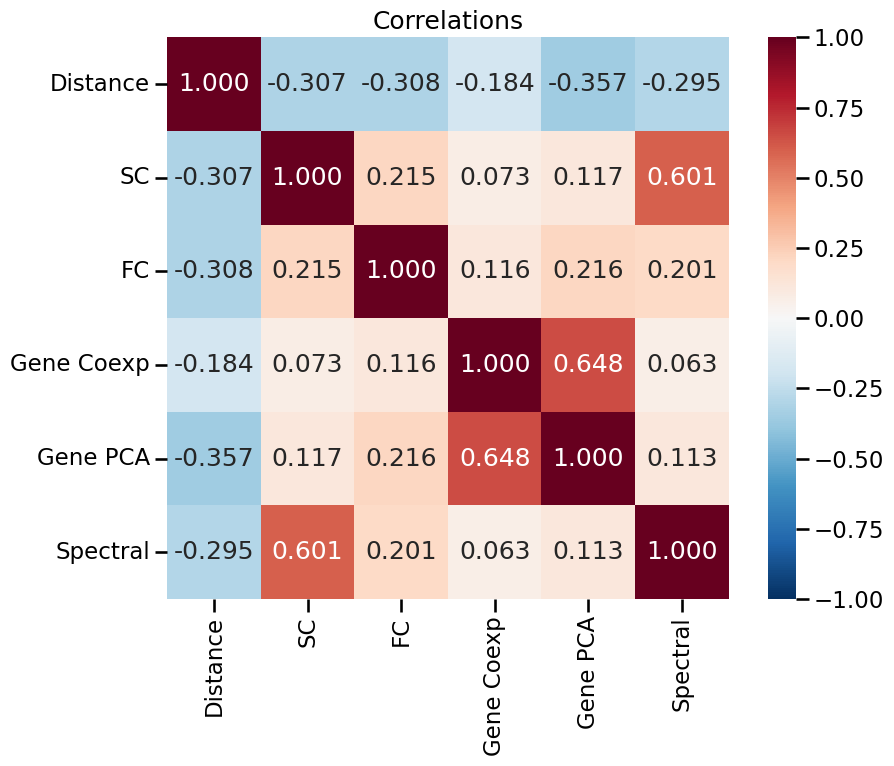


Detailed correlations:
Correlation between Distance and SC: -0.307
Correlation between Distance and FC: -0.308
Correlation between Distance and Gene Coexp: -0.184
Correlation between Distance and Gene PCA: -0.357
Correlation between Distance and Spectral: -0.295
Correlation between SC and FC: 0.215
Correlation between SC and Gene Coexp: 0.073
Correlation between SC and Gene PCA: 0.117
Correlation between SC and Spectral: 0.601
Correlation between FC and Gene Coexp: 0.116
Correlation between FC and Gene PCA: 0.216
Correlation between FC and Spectral: 0.201
Correlation between Gene Coexp and Gene PCA: 0.648
Correlation between Gene Coexp and Spectral: 0.063
Correlation between Gene PCA and Spectral: 0.113


array([[ 1.        , -0.30735148, -0.30845297, -0.18350044, -0.35717183,
        -0.29503299],
       [-0.30735148,  1.        ,  0.21521423,  0.07313917,  0.11668323,
         0.60115153],
       [-0.30845297,  0.21521423,  1.        ,  0.11596462,  0.21596834,
         0.20056463],
       [-0.18350044,  0.07313917,  0.11596462,  1.        ,  0.6484909 ,
         0.06310065],
       [-0.35717183,  0.11668323,  0.21596834,  0.6484909 ,  1.        ,
         0.11304508],
       [-0.29503299,  0.60115153,  0.20056463,  0.06310065,  0.11304508,
         1.        ]])

In [157]:
# Call the function with default parameters
analyze_feature_correlations(features)

Left hemisphere only 

In [158]:
features = construct_features_masked(
    X=AHBA_cortical_transcriptome,
    Y_sc=HCP1200_S456_structural_count_cortical, 
    Y_fc=UKBB_S456_functional_conn_cortical,
    mni_coords=cortical_mni_coords,
    mask_from=left_hemi_mask,
    mask_to=left_hemi_mask
)

print("Distances shape:", features['distances'].shape)
print("SC values shape:", features['sc_values'].shape)
print("FC values shape:", features['fc_values'].shape)
print("Gene coexpression shape:", features['gene_coexpression'].shape)
print("Gene PCA coexpression shape:", features['gene_PCA_coexpression'].shape)
print("Spectral similarity shape:", features['spectral_similarity'].shape)
print("Gene PCA shape:", features['edge_PCA_embeddings'].shape)
print("Spectral embeddings shape:", features['edge_spectral_embeddings'].shape)
print("MNI coordinates shape:", features['edge_mni_coords'].shape)

Distances shape: (18336,)
SC values shape: (18336,)
FC values shape: (18336,)
Gene coexpression shape: (18336,)
Gene PCA coexpression shape: (18336,)
Spectral similarity shape: (18336,)
Gene PCA shape: (18336, 292)
Spectral embeddings shape: (18336, 40)
MNI coordinates shape: (18336, 6)


In [159]:
# Run GLM with 1D features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

# Run GLM with all features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity', 'edge_PCA_embeddings', 'edge_spectral_embeddings', 'edge_mni_coords']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

Feature matrix shape: (18336, 6)

Full model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     729.9
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:48:48   Log-Likelihood:                 4435.3
No. Observations:               18336   AIC:                            -8859.
Df Residuals:                   18330   BIC:                            -8812.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

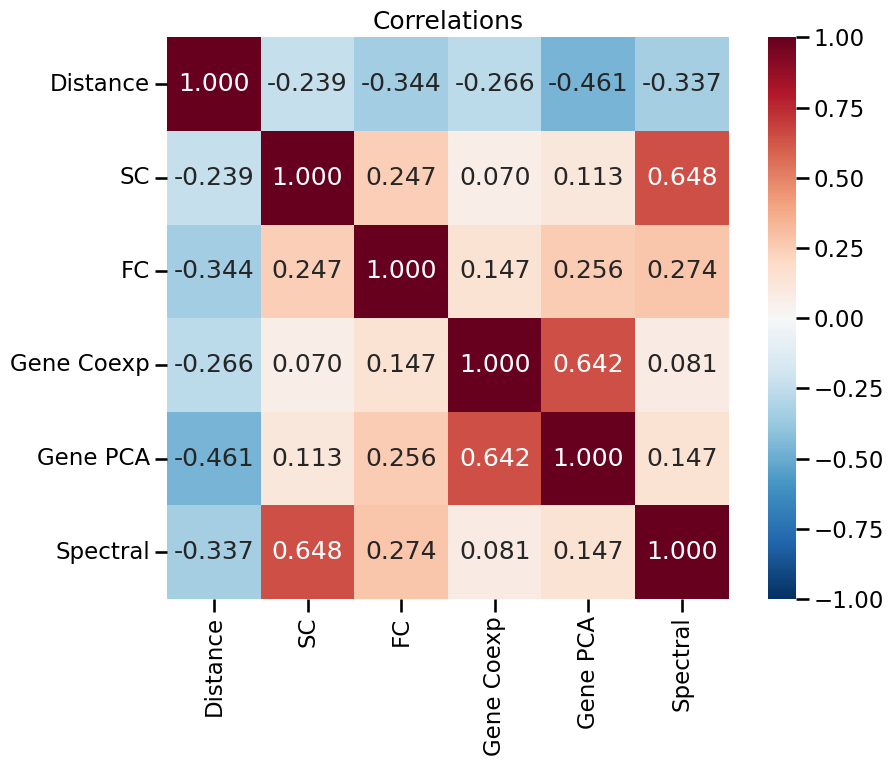


Detailed correlations:
Correlation between Distance and SC: -0.239
Correlation between Distance and FC: -0.344
Correlation between Distance and Gene Coexp: -0.266
Correlation between Distance and Gene PCA: -0.461
Correlation between Distance and Spectral: -0.337
Correlation between SC and FC: 0.247
Correlation between SC and Gene Coexp: 0.070
Correlation between SC and Gene PCA: 0.113
Correlation between SC and Spectral: 0.648
Correlation between FC and Gene Coexp: 0.147
Correlation between FC and Gene PCA: 0.256
Correlation between FC and Spectral: 0.274
Correlation between Gene Coexp and Gene PCA: 0.642
Correlation between Gene Coexp and Spectral: 0.081
Correlation between Gene PCA and Spectral: 0.147


array([[ 1.        , -0.23853711, -0.3442392 , -0.26587731, -0.461015  ,
        -0.33687411],
       [-0.23853711,  1.        ,  0.24673915,  0.07030201,  0.1127946 ,
         0.64758486],
       [-0.3442392 ,  0.24673915,  1.        ,  0.14731359,  0.2561671 ,
         0.27432099],
       [-0.26587731,  0.07030201,  0.14731359,  1.        ,  0.64233199,
         0.08053363],
       [-0.461015  ,  0.1127946 ,  0.2561671 ,  0.64233199,  1.        ,
         0.14670042],
       [-0.33687411,  0.64758486,  0.27432099,  0.08053363,  0.14670042,
         1.        ]])

In [160]:
# Call the function with default parameters
analyze_feature_correlations(features)

Right hemisphere only

In [161]:
features = construct_features_masked(
    X=AHBA_cortical_transcriptome,
    Y_sc=HCP1200_S456_structural_count_cortical, 
    Y_fc=UKBB_S456_functional_conn_cortical,
    mni_coords=cortical_mni_coords,
    mask_from=right_hemi_mask,
    mask_to=right_hemi_mask
)

print("Distances shape:", features['distances'].shape)
print("SC values shape:", features['sc_values'].shape)
print("FC values shape:", features['fc_values'].shape)
print("Gene coexpression shape:", features['gene_coexpression'].shape)
print("Gene PCA coexpression shape:", features['gene_PCA_coexpression'].shape)
print("Spectral similarity shape:", features['spectral_similarity'].shape)
print("Gene PCA shape:", features['edge_PCA_embeddings'].shape)
print("Spectral embeddings shape:", features['edge_spectral_embeddings'].shape)
print("MNI coordinates shape:", features['edge_mni_coords'].shape)


Distances shape: (10731,)
SC values shape: (10731,)
FC values shape: (10731,)
Gene coexpression shape: (10731,)
Gene PCA coexpression shape: (10731,)
Spectral similarity shape: (10731,)
Gene PCA shape: (10731, 292)
Spectral embeddings shape: (10731, 40)
MNI coordinates shape: (10731, 6)


In [162]:
# Run GLM with 1D features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

# Run GLM with all features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity', 'edge_PCA_embeddings', 'edge_spectral_embeddings', 'edge_mni_coords']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

Feature matrix shape: (10731, 6)

Full model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     451.3
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:48:52   Log-Likelihood:                 3062.0
No. Observations:               10731   AIC:                            -6112.
Df Residuals:                   10725   BIC:                            -6068.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

Interhemispheric connections only

In [163]:
features = construct_features_masked(
    X=AHBA_cortical_transcriptome,
    Y_sc=HCP1200_S456_structural_count_cortical, 
    Y_fc=UKBB_S456_functional_conn_cortical,
    mni_coords=cortical_mni_coords,
    mask_from=left_hemi_mask,
    mask_to=right_hemi_mask
)

print("Distances shape:", features['distances'].shape)
print("SC values shape:", features['sc_values'].shape)
print("FC values shape:", features['fc_values'].shape)
print("Gene coexpression shape:", features['gene_coexpression'].shape)
print("Gene PCA coexpression shape:", features['gene_PCA_coexpression'].shape)
print("Spectral similarity shape:", features['spectral_similarity'].shape)
print("Gene PCA shape:", features['edge_PCA_embeddings'].shape)
print("Spectral embeddings shape:", features['edge_spectral_embeddings'].shape)
print("MNI coordinates shape:", features['edge_mni_coords'].shape)


Distances shape: (28224,)
SC values shape: (28224,)
FC values shape: (28224,)
Gene coexpression shape: (28224,)
Gene PCA coexpression shape: (28224,)
Spectral similarity shape: (28224,)
Gene PCA shape: (28224, 292)
Spectral embeddings shape: (28224, 40)
MNI coordinates shape: (28224, 6)


In [164]:
# Run GLM with 1D features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

# Run GLM with all features
feature_names = ['distances', 'sc_values', 'gene_coexpression', 'gene_PCA_coexpression', 'spectral_similarity', 'edge_PCA_embeddings', 'edge_spectral_embeddings', 'edge_mni_coords']
results, r_squared_values = fit_glm(features, feature_names, target_name='fc_values')

Feature matrix shape: (28224, 6)

Full model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     579.7
Date:                Mon, 09 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:48:59   Log-Likelihood:                 7932.6
No. Observations:               28224   AIC:                        -1.585e+04
Df Residuals:                   28218   BIC:                        -1.580e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

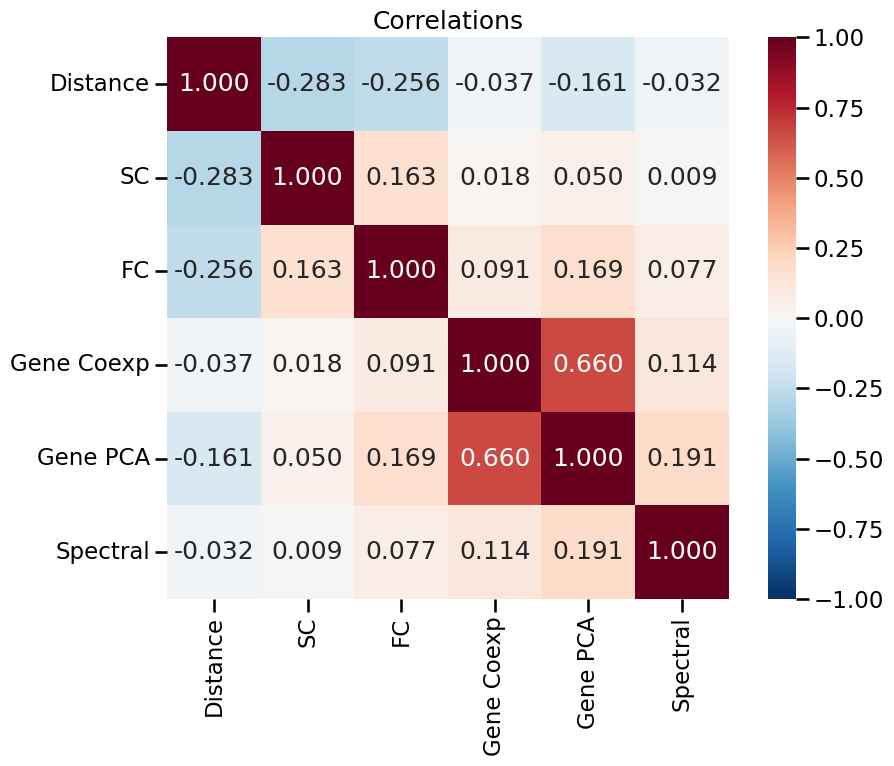


Detailed correlations:
Correlation between Distance and SC: -0.283
Correlation between Distance and FC: -0.256
Correlation between Distance and Gene Coexp: -0.037
Correlation between Distance and Gene PCA: -0.161
Correlation between Distance and Spectral: -0.032
Correlation between SC and FC: 0.163
Correlation between SC and Gene Coexp: 0.018
Correlation between SC and Gene PCA: 0.050
Correlation between SC and Spectral: 0.009
Correlation between FC and Gene Coexp: 0.091
Correlation between FC and Gene PCA: 0.169
Correlation between FC and Spectral: 0.077
Correlation between Gene Coexp and Gene PCA: 0.660
Correlation between Gene Coexp and Spectral: 0.114
Correlation between Gene PCA and Spectral: 0.191


array([[ 1.        , -0.28266103, -0.25598233, -0.03678407, -0.16077118,
        -0.03242259],
       [-0.28266103,  1.        ,  0.16271542,  0.01751436,  0.04954688,
         0.00926442],
       [-0.25598233,  0.16271542,  1.        ,  0.09125477,  0.16892273,
         0.07730623],
       [-0.03678407,  0.01751436,  0.09125477,  1.        ,  0.66037235,
         0.11374595],
       [-0.16077118,  0.04954688,  0.16892273,  0.66037235,  1.        ,
         0.19136365],
       [-0.03242259,  0.00926442,  0.07730623,  0.11374595,  0.19136365,
         1.        ]])

In [165]:
# Call the function with default parameters
analyze_feature_correlations(features)

Example learning on full dataset

In [82]:
# define a train test split object
cv_obj = RandomCVSplit(X, Y_fc, num_splits=3, shuffled=True, use_random_state=True, random_seed=42)
cv_obj.display_splits()

TRAIN: [  0   1   2   3   4   6   7   8  10  11  13  14  17  20  21  22  23  25
  26  27  28  32  33  34  36  37  39  40  43  44  46  47  48  49  50  52
  53  54  57  58  59  61  62  63  64  70  71  72  73  74  77  79  80  81
  83  84  85  86  87  88  89  91  92  93  94  95  96  99 100 102 103 104
 105 106 107 108 110 116 117 119 120 121 122 123 124 125 127 128 129 130
 131 132 134 137 138 139 140 144 146 147 148 149 150 151 152 157 160 161
 164 167 168 169 172 173 174 175 176 178 179 180 181 183 185 186 187 188
 190 191] TEST: [  5   9  12  15  16  18  19  24  29  30  31  35  38  41  42  45  51  55
  56  60  65  66  67  68  69  75  76  78  82  90  97  98 101 109 111 112
 113 114 115 118 126 133 135 136 141 142 143 145 153 154 155 156 158 159
 162 163 165 166 170 171 177 182 184 189]
TRAIN: [  1   3   5   7   8   9  12  13  14  15  16  17  18  19  20  21  24  29
  30  31  34  35  37  38  41  42  43  45  48  49  50  51  52  53  54  55
  56  57  58  59  60  63  65  66  67  68  69  71  72

In [95]:
for train_indices, test_indices in cv_obj.get_splits():
    print(train_indices, test_indices)

[  0   1   2   3   4   6   7   8  10  11  13  14  17  20  21  22  23  25
  26  27  28  32  33  34  36  37  39  40  43  44  46  47  48  49  50  52
  53  54  57  58  59  61  62  63  64  70  71  72  73  74  77  79  80  81
  83  84  85  86  87  88  89  91  92  93  94  95  96  99 100 102 103 104
 105 106 107 108 110 116 117 119 120 121 122 123 124 125 127 128 129 130
 131 132 134 137 138 139 140 144 146 147 148 149 150 151 152 157 160 161
 164 167 168 169 172 173 174 175 176 178 179 180 181 183 185 186 187 188
 190 191] [  5   9  12  15  16  18  19  24  29  30  31  35  38  41  42  45  51  55
  56  60  65  66  67  68  69  75  76  78  82  90  97  98 101 109 111 112
 113 114 115 118 126 133 135 136 141 142 143 145 153 154 155 156 158 159
 162 163 165 166 170 171 177 182 184 189]
[  1   3   5   7   8   9  12  13  14  15  16  17  18  19  20  21  24  29
  30  31  34  35  37  38  41  42  43  45  48  49  50  51  52  53  54  55
  56  57  58  59  60  63  65  66  67  68  69  71  72  74  75  76  78  80